### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, BoundaryNorm
import imageio
import seaborn as sns
import os
import mapclassify
import matplotlib as mpl
import numpy as np


### Load Florida Info

In [2]:
# Load Florida counties' geometry
fl_counties = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip")
fl_counties = fl_counties[fl_counties["STATEFP"] == "12"]  # Filter for Florida counties

# Provided county order
county_order = [
    "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
    "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
    "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
    "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
    "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
    "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
    "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
]

# Sort the GeoDataFrame based on the provided county order
fl_counties = fl_counties.set_index("NAME").reindex(county_order).reset_index()

### Files

In [3]:
yesVax = True

if yesVax:
    vax = "Vax0.1"
    patAllocFile = r"outputData\modModelVax0.1.xlsx"
    patAllocOutput = r"allocationPics\Vax0.1Results"
    heatmapOutput = r"heatmaps\Vax0.1Results"
else:
    vax = "NoVax"
    patAllocFile = r"outputData\modModelNoVax.xlsx"
    patAllocOutput = r"allocationPics\NoVaxResults"
    heatmapOutput = r"heatmaps\NoVaxResults"

### Patient Allocation

In [4]:
# File paths

os.makedirs(patAllocOutput, exist_ok=True)

# Load the data
data = pd.read_excel(patAllocFile , sheet_name="z")
data.fillna(0, inplace=True)  # Replace NA values with 0

# Rename and convert columns
data.columns = ["fromRegion", "toRegion"] + list(data.columns[2:])
data["fromRegion"] = data["fromRegion"].astype(int)
data["toRegion"] = data["toRegion"].astype(int)


# Map region IDs to county centroids (based on the provided order)
region_to_pos = {idx + 1: (row.geometry.centroid.x, row.geometry.centroid.y) for idx, row in fl_counties.iterrows()}

# Create plots for each day
frames = []
day_columns = data.columns[2:]

for day in day_columns:
    daily_data = data[["fromRegion", "toRegion", day]].copy()
    daily_data = daily_data[daily_data[day] > 0]  # Filter non-zero transfers
    if daily_data.empty:
        continue

    # Create the graph
    G = nx.DiGraph()
    for _, row in daily_data.iterrows():
        G.add_edge(int(row["fromRegion"]), int(row["toRegion"]), weight=row[day])

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw the Florida map with customized county outlines
    fl_counties.boundary.plot(ax=ax, linewidth=1.5, edgecolor="lightgray")  # Customize the boundary color and width

    # Label each county with its name at its centroid
    for idx, row in fl_counties.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row["NAME"], fontsize=8, ha="center")

    # Use the `region_to_pos` dictionary for node positions
    pos = {region: region_to_pos[region] for region in G.nodes if region in region_to_pos}

    # Draw edges only (no nodes)
    if yesVax:
        edges = nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color="cornflowerblue", width=[d["weight"] / max(nx.get_edge_attributes(G, "weight").values()) * 5 for u, v, d in G.edges(data=True)]
        )
    else:
        edges = nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color="tomato", width=[d["weight"] / max(nx.get_edge_attributes(G, "weight").values()) * 5 for u, v, d in G.edges(data=True)]
        )
    ax.set_title(f"Patient Transfers on Day {day}", fontsize=24)
    plt.axis("off")
    
    # Save plot BEFORE showing
    plot_path = os.path.join(patAllocOutput, f"travel_day_{day}_{vax}.png")
    plt.savefig(plot_path, bbox_inches="tight")
    
    # Show the plot
    #plt.show()
    plt.close(fig)

    #frames.append(imageio.imread(plot_path))


# Create GIF
#gif_path = os.path.join(output_folder, "travel_animation.gif")
#imageio.mimsave(gif_path, frames, fps=1)

print("Finished saving allocation pictures")


Finished saving allocation pictures


### Stacked Plots for Patient Allocation

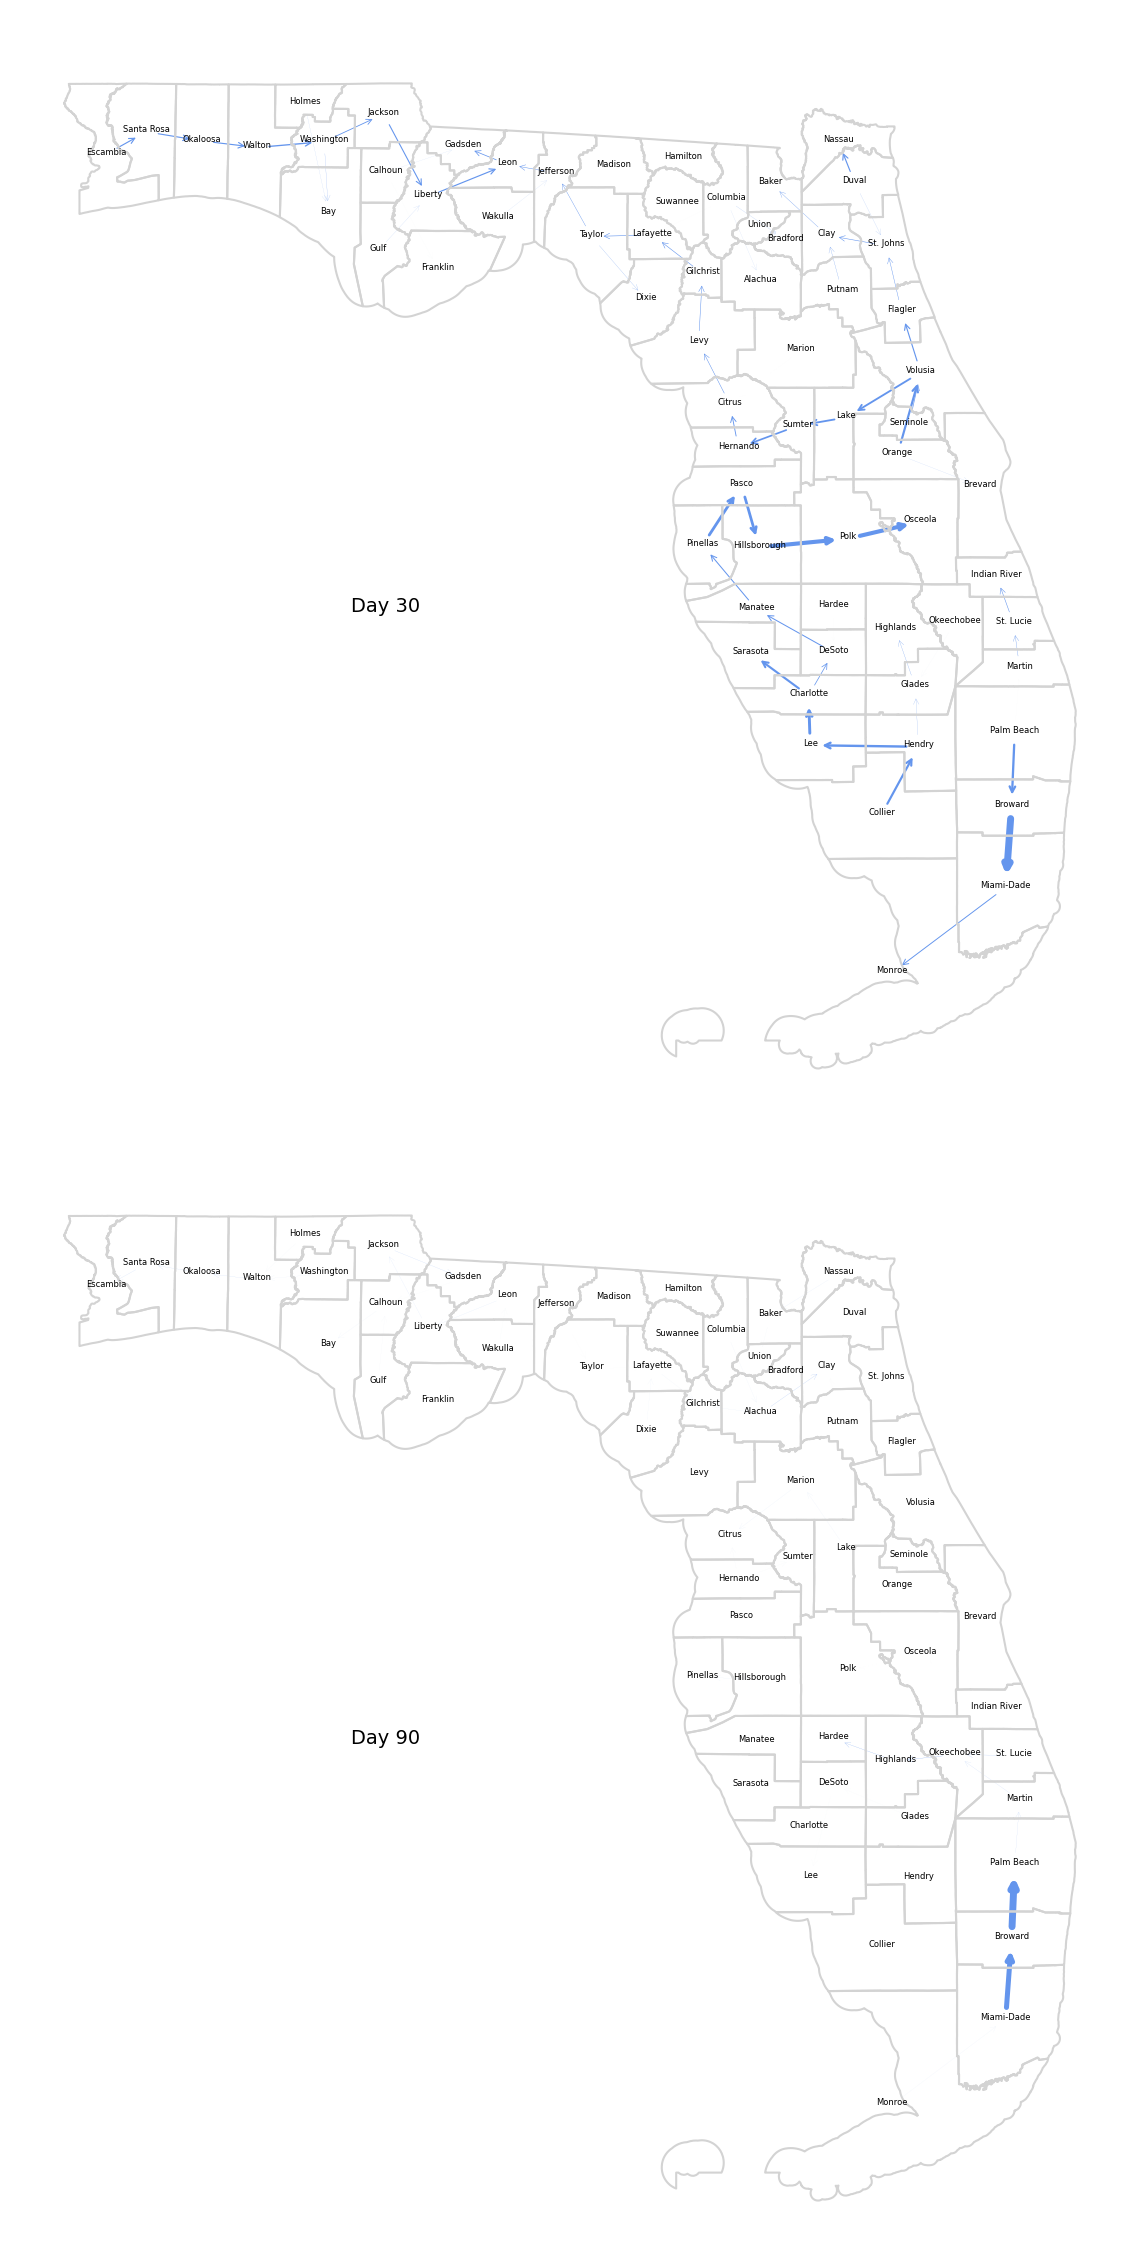

Stacked patient allocation plot saved at allocationPics\Vax0.1Results\paperStackedPatientTransfersVax0.1.png.


In [5]:
# ---------------------------
# File paths and preparation
# ---------------------------
os.makedirs(patAllocOutput, exist_ok=True)

# ---------------------------
# Load patient allocation data (sheet "z")
# ---------------------------
data = pd.read_excel(patAllocFile , sheet_name="z")
data.fillna(0, inplace=True)
# Rename columns so that the first two are region identifiers and the rest are days
data.columns = ["fromRegion", "toRegion"] + list(data.columns[2:])
data["fromRegion"] = data["fromRegion"].astype(int)
data["toRegion"] = data["toRegion"].astype(int)

# ---------------------------
# Load Florida counties' geometry
# (Make sure to uncomment these lines if not already loaded)
# ---------------------------
# fl_counties = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip")
# fl_counties = fl_counties[fl_counties["STATEFP"] == "12"]  # Filter for Florida counties
# county_order = [
#     "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
#     "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
#     "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
#     "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
#     "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
#     "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
#     "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
# ]
# fl_counties = fl_counties.set_index("NAME").reindex(county_order).reset_index()

# Create a mapping from region ID (assumed to be 1-indexed by county order) to county centroid coordinates
region_to_pos = {idx + 1: (row.geometry.centroid.x, row.geometry.centroid.y)
                 for idx, row in fl_counties.iterrows()}

# ---------------------------
# Select special days for which to stack the plots
# ---------------------------
# (These should match the day column names in your allocation data.)
special_days = ["30", "90"]

# ---------------------------
# Create the stacked plot for patient allocation
# ---------------------------
# One subplot per selected day
fig, axes = plt.subplots(nrows=len(special_days), ncols=1,
                         figsize=(15, 22.5), constrained_layout=True)

for ax, day in zip(axes, special_days):
    # Extract daily allocation data and filter for non-zero transfers
    daily_data = data[["fromRegion", "toRegion", day]].copy()
    daily_data = daily_data[daily_data[day] > 0]
    
    # Create the directed graph for patient transfers
    G = nx.DiGraph()
    for _, row in daily_data.iterrows():
        G.add_edge(int(row["fromRegion"]), int(row["toRegion"]), weight=row[day])
    
    # Plot the Florida county boundaries on the axis
    fl_counties.boundary.plot(ax=ax, linewidth=1.5, edgecolor="lightgray")
    
    # Label each county at its centroid
    for _, row in fl_counties.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row["NAME"], fontsize=6, ha="center")
    
    # Determine positions for the graph nodes using the region_to_pos mapping
    pos = {region: region_to_pos[region] for region in G.nodes() if region in region_to_pos}
    
    # Compute normalized edge widths if there are transfers for this day
    if len(G.edges()) > 0:
        max_weight = max(d["weight"] for u, v, d in G.edges(data=True))
        min_weight = min(d["weight"] for u, v, d in G.edges(data=True))  # To avoid extreme scaling
        weight_range = max_weight - min_weight if max_weight != min_weight else 1
        widths = [1 + (d["weight"] - min_weight) / weight_range * 4 for u, v, d in G.edges(data=True)]
    else:
        widths = []
    
    # Draw the transfer edges with a consistent "simple" arrow style
    if yesVax:
         edges = nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color="cornflowerblue", width=[d["weight"] / max(nx.get_edge_attributes(G, "weight").values()) * 5 for u, v, d in G.edges(data=True)]
        )
    else:
        edges = nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color="tomato", width=[d["weight"] / max(nx.get_edge_attributes(G, "weight").values()) * 5 for u, v, d in G.edges(data=True)]
        )
    
    # Place a label on the left margin (using axis-relative coordinates)
    ax.text(-85.2, 27.5, f"Day {day}",  
            fontsize=14, ha="center", va="center", color="black")
    
    ax.axis("off")

# ---------------------------
# Save and display the stacked figure
# ---------------------------
stacked_plot_path = os.path.join(patAllocOutput, f"paperStackedPatientTransfers{vax}.png")
plt.savefig(stacked_plot_path, dpi=350, bbox_inches="tight")
plt.show()

print(f"Stacked patient allocation plot saved at {stacked_plot_path}.")


### Unmet Demand Heatmap

In [6]:
# Load the 'u' sheet from the Excel file
u_data = pd.read_excel(patAllocFile, sheet_name="u")
u_data.fillna(0, inplace=True)  # Replace NaN with 0

# Load Florida counties' geometry
#fl_counties = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip")
#fl_counties = fl_counties[fl_counties["STATEFP"] == "12"]  # Filter for Florida counties

# Provided county order
#county_order = [
#    "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
#    "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
#    "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
#    "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
#    "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
#    "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
#    "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
#]

# Sort Florida counties based on the provided order
#fl_counties = fl_counties.set_index("NAME").reindex(county_order).reset_index()

# Ensure 'u_data' is aligned with the Florida counties
u_data.index = county_order

# Calculate the global min and max values for the heatmap scale
global_min = u_data.min().min()
global_max = u_data.max().max()

# Create heatmaps for each decision period
decision_periods = u_data.columns

for decision_period in decision_periods:
    fl_counties["UnmetDemand"] = u_data[decision_period].values  # Map unmet demand to counties

    # Plot the map
    fig, ax = plt.subplots(figsize=(12, 10))
    if yesVax:
        fl_counties.plot(
            column="UnmetDemand",
            cmap="Blues",
            linewidth=0.8,
            ax=ax,
            edgecolor="0.8",
            legend=True,
            legend_kwds={"label": "Unmet Hospital Demand"},
            vmin=global_min,  # Set consistent minimum value for color scale
            vmax=global_max   # Set consistent maximum value for color scale
        )
    else:
        fl_counties.plot(
            column="UnmetDemand",
            cmap="Reds",
            linewidth=0.8,
            ax=ax,
            edgecolor="0.8",
            legend=True,
            legend_kwds={"label": "Unmet Hospital Demand"},
            vmin=global_min,  # Set consistent minimum value for color scale
            vmax=global_max   # Set consistent maximum value for color scale
        )

    # Add county labels
    for idx, row in fl_counties.iterrows():
        centroid = row.geometry.centroid  # Get centroid of each county
        ax.text(
            centroid.x, centroid.y, row["NAME"],
            fontsize=6, ha="center", color="black"
        )

    plt.title(f"Unmet Hospital Demand on Day {decision_period}", fontsize=24)
    plt.axis("off")

    # Save the heatmap as an image
    output_file = os.path.join(heatmapOutput, f"heatmap_decision_period_{decision_period}_{vax}.png")
    plt.savefig(output_file, dpi=350, bbox_inches="tight")
    #plt.show()
    plt.close(fig)

print(f"Heatmaps created for all decision periods in {heatmapOutput}.")


Heatmaps created for all decision periods in heatmaps\Vax0.1Results.


### Unmet Demand Stacked Plots

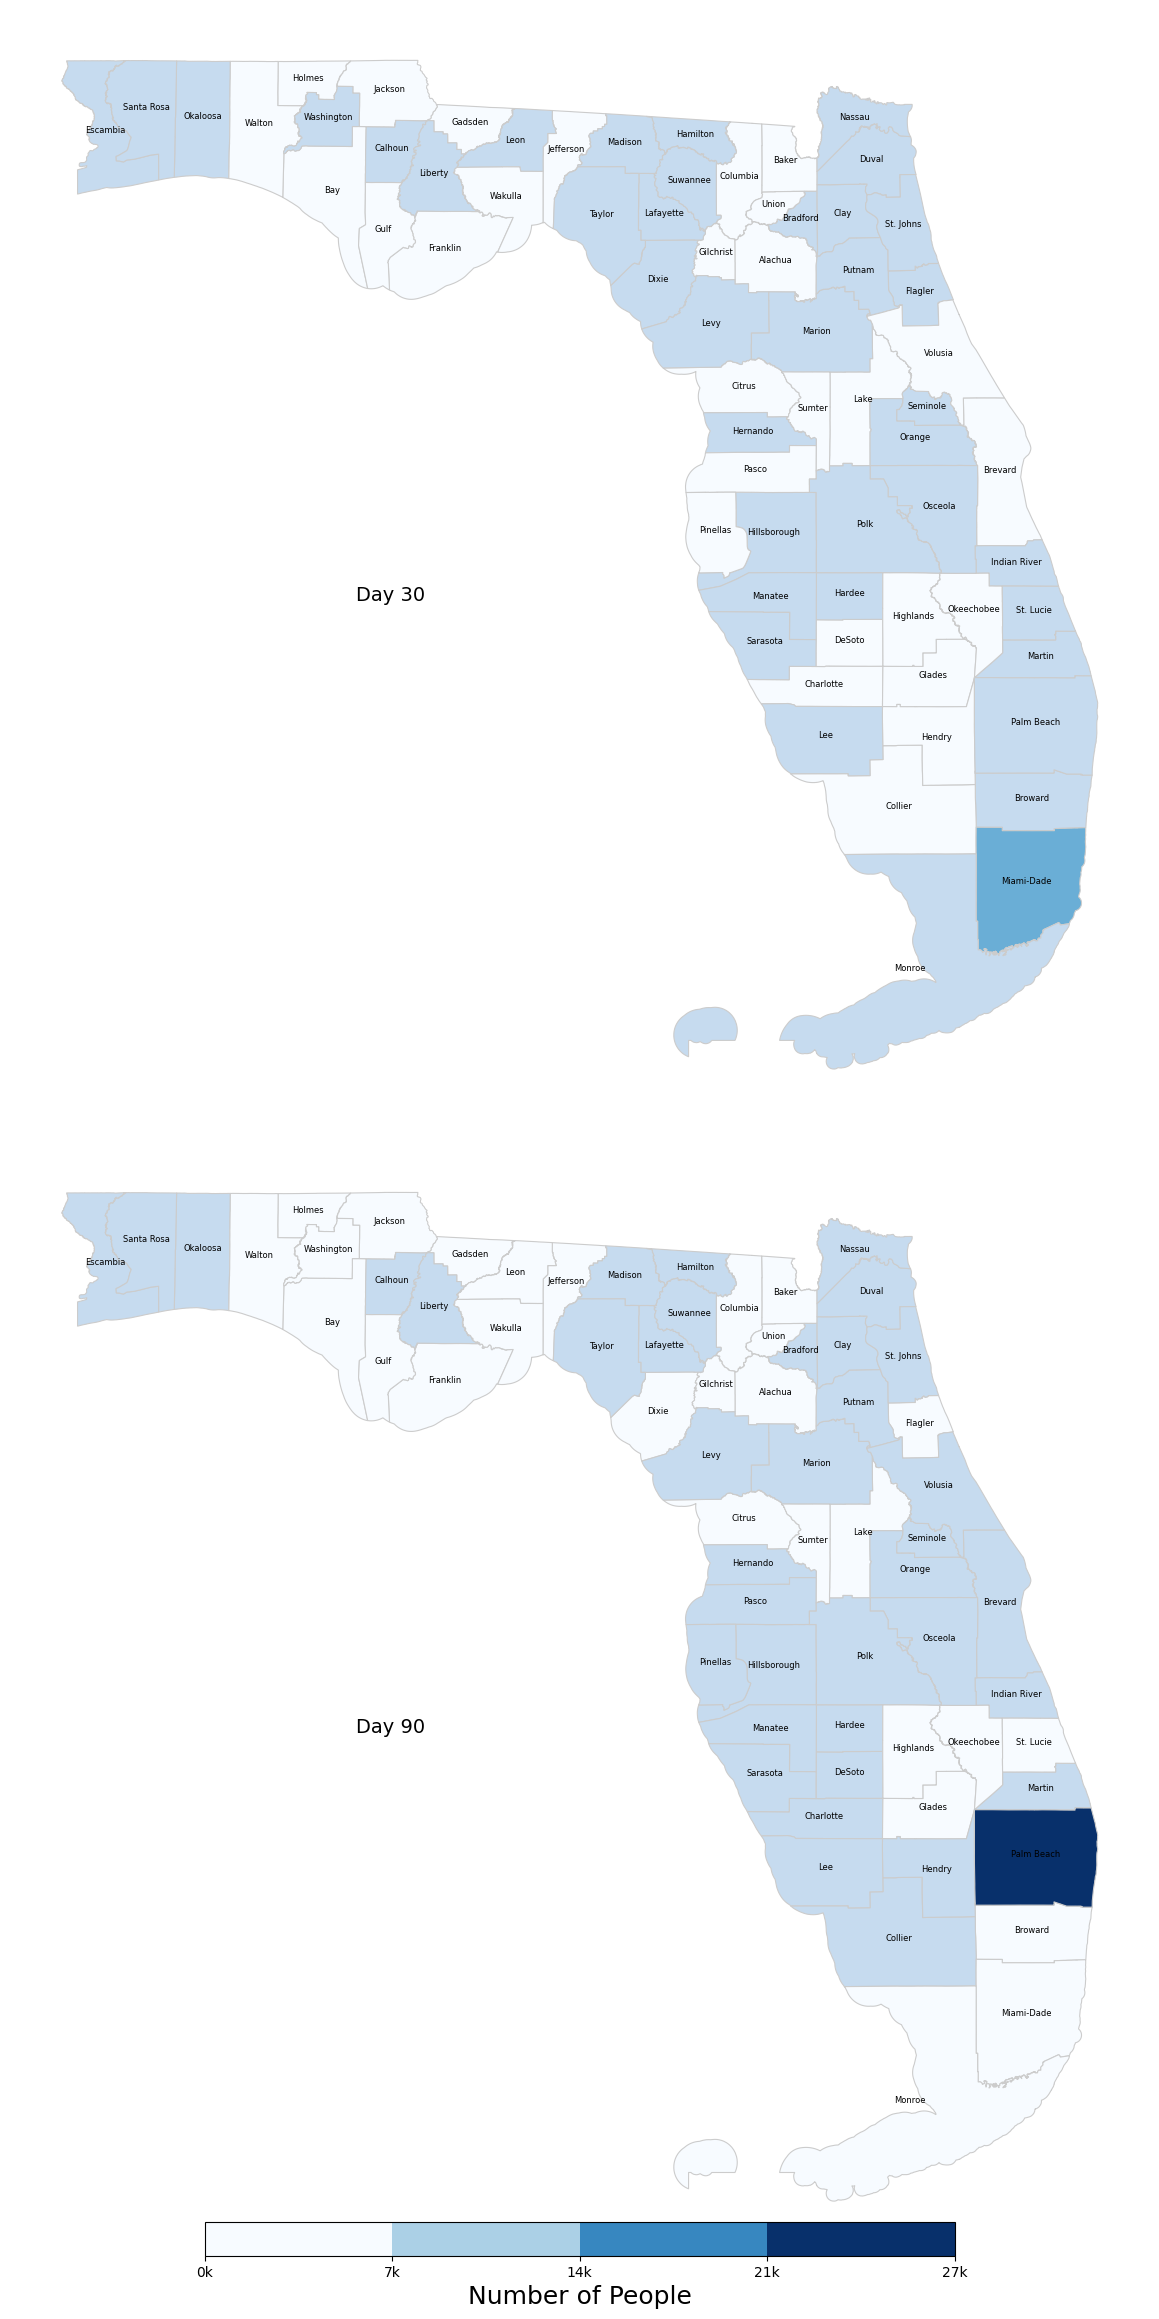

Special heatmap created at heatmaps\Vax0.1Results\paperStackedHeatmapVax0.1.png.


In [7]:

u_data = pd.read_excel(patAllocFile, sheet_name="u")
u_data.fillna(0, inplace=True)  # Replace NaN with 0

# Load Florida counties' geometry
#fl_counties = gpd.read_file(
#    "https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip"
#)
#fl_counties = fl_counties[fl_counties["STATEFP"] == "12"]  # Keep only Florida

# Provided county order
#county_order = [
#    "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", 
#    "Citrus", "Clay", "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", 
#    "Franklin", "Gadsden", "Gilchrist", "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", 
#    "Hernando", "Highlands", "Hillsborough", "Holmes", "Indian River", "Jackson", "Jefferson", 
#    "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", "Manatee", "Marion", 
#    "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
#    "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", 
#    "Seminole", "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", 
#    "Volusia", "Wakulla", "Walton", "Washington"
#]

# Reindex Florida counties by the provided order
fl_counties = fl_counties.set_index("NAME").reindex(county_order).reset_index()

# Ensure u_data aligns with those counties
u_data.index = county_order

# Set up discrete bins
# For example: 0–5k, 5k–40k, 40k–60k, 60k–120k, 120k–136k
bins = np.linspace(0, 27000, num=5)

# Create a discrete color norm & colormap
if yesVax:
    cmap = mpl.cm.Blues
    norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N)
else:
    cmap = mpl.cm.Reds
    norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N)

# Build a scalar mappable that the colorbar can use
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # No data needed; we only use this for the colorbar

# Plot the subplots
special_days = ["30", "90"]
day_labels   = [f"Day {i}" for i in special_days]

fig, axes = plt.subplots(
    nrows=len(special_days), ncols=1, 
    figsize=(15, 22.5), 
    constrained_layout=True
)
#fig.suptitle("Unmet Demand (Vaccinated)", fontsize=24)

for ax, day, label in zip(axes, special_days, day_labels):
    # Copy the day’s unmet demand into the GeoDataFrame
    fl_counties["UnmetDemand"] = u_data[day].values

    # Plot using the discrete classification scheme
    fl_counties.plot(
        column="UnmetDemand",
        cmap=cmap,
        scheme="UserDefined",
        classification_kwds={"bins": bins},
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=False  # We'll add one shared legend below
    )

    # Label counties at their centroids
    for idx, row in fl_counties.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, 
            row["NAME"], 
            fontsize=6, 
            ha="center", 
            color="black"
        )

    # A label on the left margin for each subplot
    ax.text(
        -85.2, 27.5, label,  
        fontsize=14, ha="center", va="center", color="black"
    )
    ax.axis("off")

#Discrete Color Bar
cbar_ax = fig.add_axes([0.25, 0.0, 0.5, 0.015])  # X, Y, width, height
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Number of People", fontsize=18)

# Optional: Tweak tick locations & labels if desired
cbar.set_ticks(bins)
from math import ceil, floor
cbar.ax.set_xticklabels([f"{ceil(i/1000):.2g}k" for i in bins])


# Save and Display Image
stackedOutput = os.path.join(heatmapOutput, f"paperStackedHeatmap{vax}.png")
plt.savefig(stackedOutput, dpi=350, bbox_inches="tight")
plt.show()

print(f"Special heatmap created at {stackedOutput}.")
